<a href="https://colab.research.google.com/github/RishithaAppikonda/DermaVision/blob/main/DermaVision_GH_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Required Libraries


In [ ]:
# Install required libraries
!pip install kaggle
!pip install pandas
!pip install matplotlib
!pip install opencv-python
!pip install tensorflow
!pip install scikit-learn
!pip install xgboost
!pip install joblib

### Skin Cancer MNIST: HAM10000 Dataset

In [ ]:
# create the kaggle directory
!mkdir -p ~/.kaggle
# copy the kaggle json into the kaggle directory
!cp kaggle.json ~/.kaggle/
# Change the permissions so the file is only visible to the user
!chmod 600 ~/.kaggle/kaggle.json
# Download the dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
#unzip the dataset
!unzip skin-cancer-mnist-ham10000.zip -d HAM10000


Streaming output truncated to the last 5000 lines.
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: HAM10000/ham10000_images_part_2/ISIC_002

In [ ]:
IMAGE_PATH_1 = "HAM10000/HAM10000_images_part_1/"
IMAGE_PATH_2 = "HAM10000/HAM10000_images_part_2/"
METADATA_PATH = "HAM10000/HAM10000_metadata.csv"
IMG_SIZE = 224 # Added image size

In [ ]:
import pandas as pd
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from IPython import get_ipython
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

### Preprocessing Techniques

In [ ]:
# Create the dataframe for patient's data
df = pd.read_csv(METADATA_PATH)

In [ ]:
#mapping of image path with image_id in the strctured data.

def get_image_path(image_id):
    path_1 = os.path.join(IMAGE_PATH_1, image_id + ".jpg")
    path_2 = os.path.join(IMAGE_PATH_2, image_id + ".jpg")
    return path_1 if os.path.exists(path_1) else path_2

# Create the image path column
df['image_path'] = df['image_id'].apply(get_image_path)


In [ ]:
def preprocess_structured_data(df_input): #Accept the data frame as an argument
    df = df_input.copy()
    # Handle missing values
    df['age'] = df['age'].fillna(df['age'].median())
    df.fillna("unknown", inplace=True)  # Fill other missing categorical values

    # Encode categorical labels
    le_dx = LabelEncoder()  # LabelEncoder for dx (disease labels)
    df['dx'] = le_dx.fit_transform(df['dx'])

    le_sex = LabelEncoder()
    df['sex'] = le_sex.fit_transform(df['sex'])  # Encode gender (0: female, 1: male)

    le_localization = LabelEncoder()
    df['localization'] = le_localization.fit_transform(df['localization'])  # Encode body part

    # Scale numerical features
    scaler = StandardScaler()
    df['age'] = scaler.fit_transform(df[['age']])

    # Return label encoders separately
    return df, le_dx, le_sex, le_localization

In [ ]:
# Execute preprocessing
df, le_dx, le_sex, le_localization = preprocess_structured_data(df) #pass df
X_structured = df[['age', 'sex', 'localization']]
y_labels = df['dx']

In [ ]:
# Split the data into train, validation, and test sets
def split_data_indices(df, y_labels, test_size=0.2, val_size = 0.5, seed=42):
    num_samples = len(df)
    indices = np.arange(num_samples)

    X_train_indices, X_temp_indices, y_train, y_temp = train_test_split(indices, y_labels, test_size=test_size, random_state=seed, stratify=y_labels)
    X_val_indices, X_test_indices, y_val, y_test = train_test_split(X_temp_indices, y_temp, test_size=val_size, random_state=seed, stratify=y_temp)


    return X_train_indices, X_val_indices, X_test_indices, y_train, y_val, y_test

In [ ]:
# Split data into train/val/test indices and labels
X_train_indices, X_val_indices, X_test_indices, y_train, y_val, y_test = split_data_indices(df, y_labels)

# Create dataframes for each split
df_train = df.iloc[X_train_indices]
df_val = df.iloc[X_val_indices]
df_test = df.iloc[X_test_indices]
X_structured_train = X_structured.iloc[X_train_indices]
X_structured_val = X_structured.iloc[X_val_indices]
X_structured_test = X_structured.iloc[X_test_indices]

In [ ]:
# Generator for processing images in batches
def image_generator(df, batch_size=32, y_labels = None):
    num_samples = len(df)
    if y_labels is None:
         y_labels = np.zeros(num_samples) # make a dummy set of labels
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_df = df.iloc[offset:offset+batch_size]
            batch_y = y_labels[offset:offset+batch_size]
            images = []

            for image_path in batch_df['image_path']:
                img = cv2.imread(image_path)
                if img is None:
                    img = np.zeros((IMG_SIZE, IMG_SIZE, 3))  # Handle missing images
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                images.append(img)

            yield np.array(images), np.array(batch_y)

In [ ]:
# Create image generators for each split
train_gen = image_generator(df_train, batch_size=32, y_labels = y_train)
val_gen = image_generator(df_val, batch_size=32, y_labels = y_val)
test_gen = image_generator(df_test, batch_size=32, y_labels = y_test)

In [ ]:
#printing sizes of Train, Test and Validation Datasets.

print(f"Image Data - Train: {len(X_train_indices)}, Validation: {len(X_val_indices)}, Test: {len(X_test_indices)}")
print(f"Structured Data - Train: {len(X_structured_train)}, Validation: {len(X_structured_val)}, Test: {len(X_structured_test)}")
print("Preprocessing complete! Structured data and image generators ready.")


Image Data - Train: 8012, Validation: 1001, Test: 1002
Structured Data - Train: 8012, Validation: 1001, Test: 1002
Preprocessing complete! Structured data and image generators ready.


In [ ]:
# Display first 5 rows of the preprocessed structured data

print("First 5 rows of structured data:")
print(X_structured.head())
# Get unique disease types
unique_diseases = df['dx'].unique()


First 5 rows of structured data:
        age  sex  localization
0  1.663522    1            11
1  1.663522    1            11
2  1.663522    1            11
3  1.663522    1            11
4  1.368014    1             4


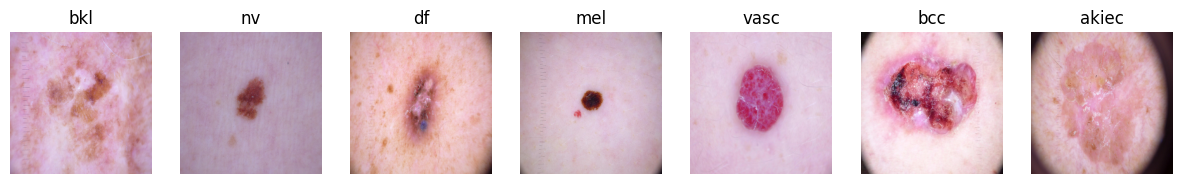

In [ ]:
# Select one sample per disease type
selected_images = []
selected_labels = []

for disease in unique_diseases:
    sample = df[df['dx'] == disease].iloc[0]  # Take the first occurrence
    img = cv2.imread(sample['image_path']) # This is where the error happens.
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        selected_images.append(img)
        selected_labels.append(le_dx.inverse_transform([sample['dx']])[0])   # Decode label

# Display images with labels
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))
for i in range(len(selected_images)):
    axes[i].imshow(selected_images[i].astype("uint8"))
    axes[i].set_title(selected_labels[i])  # Set the disease label
    axes[i].axis("off")

plt.show()


### CNN Models

In [ ]:
# Function to create CNN models
def create_cnn_model(base_model, num_classes):
    base_model.trainable = False  # Freeze the pretrained base model
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


In [ ]:
# Define number of classes
num_classes = len(set(y_labels))

# EfficientNet Model
base_model_efficientnet = EfficientNetB0(weights='imagenet', include_top=False)
efficientnet_model = create_cnn_model(base_model_efficientnet, num_classes)
efficientnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ResNet Model
base_model_resnet = ResNet50(weights='imagenet', include_top=False)
resnet_model = create_cnn_model(base_model_resnet, num_classes)
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training parameters
batch_size = 50
epochs = 8
steps_per_epoch = len(X_train_indices) // batch_size
validation_steps = len(X_val_indices) // batch_size


In [ ]:
# Train EfficientNet
efficientnet_history = efficientnet_model.fit(  # save the returned history object
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[early_stopping]
)

# Train ResNet
resnet_history = resnet_model.fit(  # save the returned history object
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs,
    callbacks=[early_stopping]
)

print("CNN Training Complete!")

Epoch 1/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 84s 362ms/step - accuracy: 0.6043 - loss: 1.1835 - val_accuracy: 0.6719 - val_loss: 0.9181
Epoch 2/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 59s 371ms/step - accuracy: 0.6974 - loss: 0.8358 - val_accuracy: 0.7212 - val_loss: 0.7418
Epoch 3/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 76s 475ms/step - accuracy: 0.7129 - loss: 0.7657 - val_accuracy: 0.7422 - val_loss: 0.7045
Epoch 4/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.7462 - loss: 0.6992 - val_accuracy: 0.7328 - val_loss: 0.7313
Epoch 5/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 40s 253ms/step - accuracy: 0.7607 - loss: 0.6703 - val_accuracy: 0.7731 - val_loss: 0.6167
Epoch 6/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.7735 - loss: 0.6280 - val_accuracy: 0.7578 - val_loss: 0.6486
Epoch 7/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 39s 243ms/step - accuracy: 0.7930 - loss: 0.6026 - val_accuracy: 0.7504 - val_loss: 0.6354
Epoch 8/8
160/160 ━━━━━━━━━━━━━━━━━━━━ 80s 503ms/step - accuracy: 0.7802 - loss: 0.6152 - 

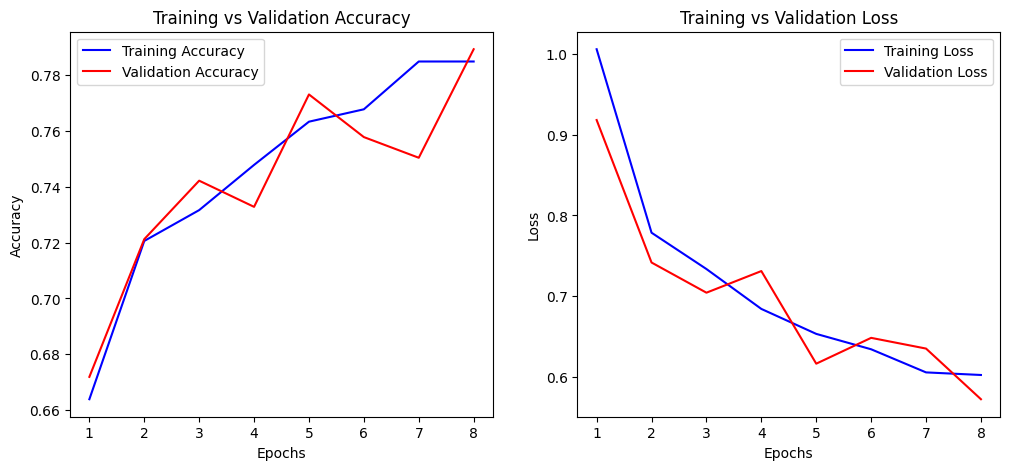

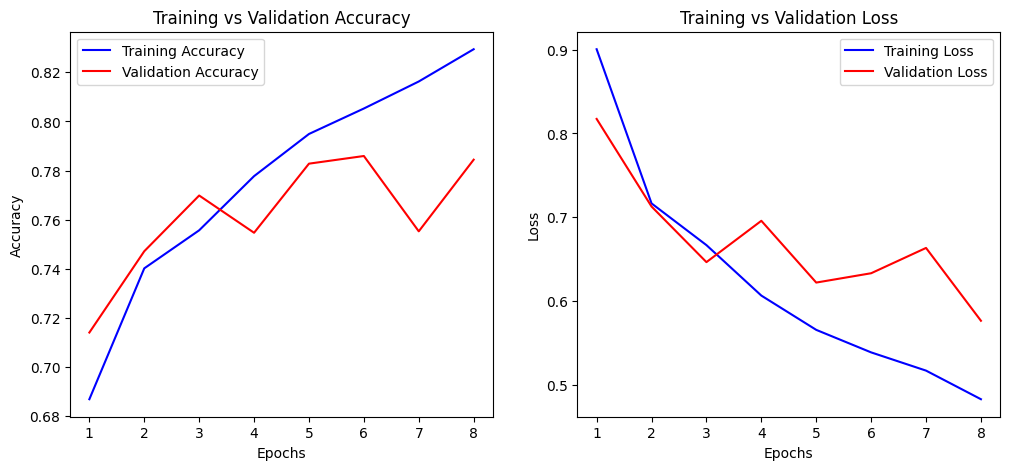

In [ ]:
# vizual representation of the accuracy-loss of EfficientNetB0 and ResNet50.

def plot_training_history(history):
    # Extract loss and accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()

# Call the function
plot_training_history(efficientnet_history)
plot_training_history(resnet_history)


### ML Models

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with Cross-Validation
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_structured_train, y_train)

# Get best parameters
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

# Train best model
best_rf_model = rf_grid_search.best_estimator_

# Evaluate with cross-validation
rf_cv_scores = cross_val_score(best_rf_model, X_structured_train, y_train, cv=5, scoring='accuracy')
print("Random Forest Cross-Validation Accuracy:", np.mean(rf_cv_scores))

rf_model=best_rf_model


Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Cross-Validation Accuracy: 0.7040682147938907


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define hyperparameter grid
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize the model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Perform Randomized Search with Cross-Validation
xgb_random_search = RandomizedSearchCV(xgb_model, xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, n_iter=20)
xgb_random_search.fit(X_structured_train, y_train)

# Get best parameters
print("Best XGBoost Parameters:", xgb_random_search.best_params_)

# Train best model
best_xgb_model = xgb_random_search.best_estimator_

# Evaluate with cross-validation
xgb_cv_scores = cross_val_score(best_xgb_model, X_structured_train, y_train, cv=5, scoring='accuracy')
print("XGBoost Cross-Validation Accuracy:", np.mean(xgb_cv_scores))

xgb_model=best_xgb_model

Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGBoost Cross-Validation Accuracy: 0.70469259028211


### Ensemble Model

In [ ]:
# Reduce batch size if needed
batch_size = 32

# Optimize CNN predictions
val_images, val_labels = next(val_gen)  # Load only one batch
cnn_efficientnet_preds = efficientnet_model.predict(val_images, batch_size=batch_size)
cnn_resnet_preds = resnet_model.predict(val_images, batch_size=batch_size)

# Optimize ML model predictions
batch_size_ml = 1000
rf_probs = rf_model.predict_proba(X_structured_val.iloc[:batch_size]) # Use same batch size as CNN
xgb_probs = xgb_model.predict_proba(X_structured_val.iloc[:batch_size]) # Use same batch size as CNN

print("Predictions completed successfully!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions completed successfully!


In [ ]:
# Define weights for each model
cnn_weight = 0.35
rf_weight = 0.20
xgb_weight = 0.20
resnet_weight = 0.35

# Ensure all predictions are for the same number of samples
num_samples = min(cnn_efficientnet_preds.shape[0], rf_probs.shape[0], len(y_val)) # Added len(y_val)

# Slice the arrays to match the smallest number of samples
cnn_efficientnet_preds = cnn_efficientnet_preds[:num_samples]
cnn_resnet_preds = cnn_resnet_preds[:num_samples]
rf_probs = rf_probs[:num_samples]
xgb_probs = xgb_probs[:num_samples]
y_val = y_val[:num_samples] # Slice y_val to match

# Weighted sum of probabilities
final_probs = (
    (cnn_weight * cnn_efficientnet_preds) +
    (resnet_weight * cnn_resnet_preds) +
    (rf_weight * rf_probs) +
    (xgb_weight * xgb_probs)
)

# Get final class predictions
final_preds = np.argmax(final_probs, axis=1)

# Evaluate ensemble performance
ensemble_acc = accuracy_score(y_val, final_preds)
print("Ensemble Accuracy:", ensemble_acc)
print("Classification Report:\n", classification_report(y_val, final_preds, zero_division=0))

Ensemble Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       1.00      0.33      0.50         3
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.83      1.00      0.91        25

    accuracy                           0.81        32
   macro avg       0.37      0.27      0.28        32
weighted avg       0.74      0.81      0.76        32



In [ ]:
# After training EfficientNet
efficientnet_model.save("efficientnet_model.keras")

# After training ResNet
resnet_model.save("resnet_model.keras")

# Save the ML models using joblib
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")


['xgb_model.pkl']

### User Input

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Enter the path to the skin lesion image: /content/HAM10000/ham10000_images_part_2/ISIC_0030276.jpg
Enter patient age: 80
Enter patient sex (male/female): male
Enter lesion location (e.g., back, scalp, face, etc.): back
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


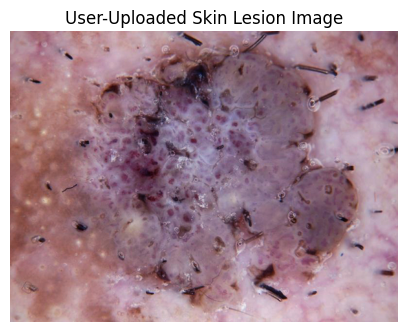

🩺 Predicted Disease: nv


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model
import joblib

# Load the saved models
efficientnet_model = load_model("efficientnet_model.keras")
resnet_model = load_model("resnet_model.keras")
rf_model = joblib.load("rf_model.pkl")
xgb_model = joblib.load("xgb_model.pkl")

# Recompile the models (to update optimizer state)
efficientnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

def preprocess_user_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img_resized = cv2.resize(img, (224, 224))   # Resize for model
    img_normalized = np.array(img_resized, dtype=np.float32) / 255.0  # Normalize
    return img, np.expand_dims(img_normalized, axis=0)  # Return both original and processed image

# Take image input from user
user_image_path = input("Enter the path to the skin lesion image: ")
original_image, user_image = preprocess_user_image(user_image_path)



# Take structured data input
user_age = float(input("Enter patient age: "))
user_sex = input("Enter patient sex (male/female): ")
user_localization = input("Enter lesion location (e.g., back, scalp, face, etc.): ")

# Encode categorical values
user_sex = 1 if user_sex.lower() == "male" else 0
user_localization = le_localization.transform([user_localization])[0]

# Create structured data array with feature names
feature_names = ['age', 'sex', 'localization']
user_structured_data = np.array([[user_age, user_sex, user_localization]])
user_structured_data_df = pd.DataFrame(user_structured_data, columns=feature_names)

# CNN Model Predictions
cnn_eff_pred = efficientnet_model.predict(user_image)
cnn_res_pred = resnet_model.predict(user_image)

# ML Model Predictions (using DataFrame with feature names)
rf_prob = rf_model.predict_proba(user_structured_data_df[['age', 'sex', 'localization']])
xgb_prob = xgb_model.predict_proba(user_structured_data_df[['age', 'sex', 'localization']])

# Weighted Ensemble Prediction
final_prob = (
    (0.35 * cnn_eff_pred) +
    (0.35 * cnn_res_pred) +
    (0.15 * rf_prob) +
    (0.15 * xgb_prob)
)

# Get the predicted index
final_prediction_idx = np.argmax(final_prob, axis=1)[0]

# Decode the predicted disease (dx) using le_dx
predicted_disease = le_dx.inverse_transform([final_prediction_idx])[0]

# Display the user-uploaded image
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.axis("off")
plt.title("User-Uploaded Skin Lesion Image")
plt.show()

# Print the final prediction result
print(f"🩺 Predicted Disease: {predicted_disease}")
